# MOFA+: training a model in Python
Author: Ricard Argelaguet.    
Affiliation: European Bioinformatics Institute, Cambridge, UK.  
Date: 13/11/2019  



This notebook contains a detailed tutorial on how to train MOFA using Python.
A template script to run the code below can be found [here](https://github.com/bioFAM/MOFA2/tree/master/inst/scripts).

## 1) Load libraries

In [1]:
from mofapy2.run.entry_point import entry_point
import pandas as pd
import numpy as np

# initialise the entry point
ent = entry_point()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


## 2) Load data

To create a MOFA+ object you need to specify four dimensions: samples (cells), features, view(s) and group(s). MOFA objects can be created from a wide range of input formats:

### 2.1) pandas data.frame format
A pandas data.frame with columns `sample`, `group`, `feature`, `view`, `value`.  This is the most intuitive format, as it summarises all omics/groups in a single data structure. Also, there is no need to add rows that correspond to missing data.

For example:
```
sample   group   feature    value   view
sample1  groupA  gene1      2.8044  RNA
sample1  groupA  gene3      2.2069  RNA
sample2  groupB  gene2      0.1454  RNA
sample2  groupB  gene1      2.7021  RNA
sample2  groupB  promoter1  3.8618  Methylation
sample3  groupB  promoter2  3.2545  Methylation
sample3  groupB  promoter3  1.5014  Methylation
```

Here we load a simulated data set with the following dimensions:

In [2]:
data_dt = pd.read_csv("cinque.csv")
data_dt.head()

,sample,group,feature,view,value
0,sample_0_group_0,group_0,rs_CLEC3A_RNA,RNA,0.892818
1,sample_1_group_0,group_0,rs_CLEC3A_RNA,RNA,6.580103
2,sample_2_group_0,group_0,rs_CLEC3A_RNA,RNA,14.123672
3,sample_3_group_0,group_0,rs_CLEC3A_RNA,RNA,10.606501
4,sample_4_group_0,group_0,rs_CLEC3A_RNA,RNA,13.189237


In [3]:
data_dt.shape

(1048575, 5)

In [4]:
D = [705,705] # Number of features per view
M = len(D)      # Number of views
K = 2           # Number of factors
N = [895631,152944]   # Number of samples per group
#G = len(705)      # Number of groups

data_dt = pd.read_csv("http://ftp.ebi.ac.uk/pub/databases/mofa/getting_started/data.txt.gz", sep="\t")
data_dt

,sample,group,feature,view,value
0,sample_0_group_0,group_0,feature_0_view_0,view_0,-2.05
1,sample_1_group_0,group_0,feature_0_view_0,view_0,0.10
2,sample_2_group_0,group_0,feature_0_view_0,view_0,1.44
3,sample_3_group_0,group_0,feature_0_view_0,view_0,-0.28
4,sample_4_group_0,group_0,feature_0_view_0,view_0,-0.88
...,...,...,...,...,...
399995,sample_95_group_1,group_1,feature_999_view_1,view_1,0.21
399996,sample_96_group_1,group_1,feature_999_view_1,view_1,0.47
399997,sample_97_group_1,group_1,feature_999_view_1,view_1,0.49
399998,sample_98_group_1,group_1,feature_999_view_1,view_1,0.19


### 2.2) List of matrices
A nested list of numpy arrays, where the first index refers to the view and the second index refers to the group. Samples are stored in the rows and features are stored in the columns. All views for a given group G must have the same samples in the rows. If there is any sample that is missing a particular view, the column needs to be filled with NAs.

Loading the same data above in matrix format:

In [24]:
data_prefix = "http://ftp.ebi.ac.uk/pub/databases/mofa/getting_started/"
data_mat = [[None for g in range(G)] for m in range(M)]
for m in range(M):
    for g in range(G):
        data_mat[m][g] = np.loadtxt("%s/%d_%d.txt.gz" % (data_prefix,m,g), delimiter="\t")

In [25]:
data_mat

[[array([[-0.16,  1.12, -0.01, ...,  2.46, -0.54,  2.06],
         [-1.37, -0.37,  0.51, ..., -0.68, -0.1 ,  0.32],
         [-0.01, -0.66, -1.03, ...,  1.58,  1.11,  0.09],
         ...,
         [-2.3 , -0.54,  0.11, ...,  0.23,  0.83, -2.01],
         [ 0.51, -1.11, -0.69, ..., -0.21,  0.39,  1.64],
         [ 0.34,  0.38,  1.05, ..., -0.67,  1.49,  0.41]]),
  array([[ 3.57,  0.69, -0.23, ...,  0.02,  0.27, -0.89],
         [-4.25,  1.22, -0.71, ..., -0.61,  0.45,  0.91],
         [-0.05, -1.21,  0.54, ...,  0.25,  1.11, -0.06],
         ...,
         [ 0.17,  0.98,  0.25, ...,  0.03,  0.58,  0.43],
         [-0.07, -1.54,  0.43, ...,  1.3 ,  0.28, -0.92],
         [-2.42,  1.49, -0.96, ...,  0.19,  1.44,  0.61]])],
 [array([[-0.19, -1.48,  0.61, ...,  0.47, -0.97, -1.17],
         [ 1.17, -1.96, -0.57, ...,  0.66, -0.98,  0.81],
         [ 0.92,  0.27,  0.11, ..., -2.21,  0.67, -0.2 ],
         ...,
         [ 1.33,  0.06,  0.33, ...,  0.23, -0.23, -0.66],
         [-0.57, -1.18, -

### 2.3 Define data options
- **scale_views**: if views have different ranges/variances, it is good practice to scale each view to unit variance. Default is False

In [3]:
ent.set_data_options(
    scale_views = False
)

### 2.4) Add the data to the model

This has to be run after defining the data options
- **likelihoods**: a list of strings, either "gaussian" (default), "poisson" or "bernoulli"

In [4]:
# option 1: data.frame format
ent.set_data_df(data_dt, likelihoods = ["gaussian","gaussian", 'gaussian'])

# option 2: nested matrix format
#ent.set_data_matrix(data_mat, likelihoods = ["gaussian","gaussian"])



Loaded group='group_0' view='RNA' with N=705 samples and D=560 features...
Loaded group='group_0' view='copy_number' with N=705 samples and D=733 features...
Loaded group='group_0' view='mutation_number' with N=705 samples and D=22 features...
Loaded group='group_1' view='RNA' with N=705 samples and D=82 features...
Loaded group='group_1' view='copy_number' with N=705 samples and D=169 features...
Loaded group='group_1' view='mutation_number' with N=705 samples and D=4 features...




## 3) Set model options

- **factors**: number of factors
- **spikeslab_weights**: use spike-slab sparsity prior in the weights? default is TRUE
- **ard_weights**: use ARD prior in the weights? Default is TRUE if using multiple views.

Only change the default model options if you are familiar with the underlying mathematical model!


In [5]:
ent.set_model_options(
    factors = 5, 
    spikeslab_weights = True, 
    ard_weights = True
)


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (RNA): gaussian
- View 1 (copy_number): gaussian
- View 2 (mutation_number): gaussian




## 4) Set training options

- **convergence_mode**: "fast" (default), "medium", "slow".
- **dropR2**: minimum variance explained criteria to drop factors while training
- **gpu_mode**: use GPU? (needs cupy installed and a functional GPU, see https://biofam.github.io/MOFA2/gpu_training.html)
- **seed**: random seed

In [6]:
ent.set_train_options(
    convergence_mode = "medium", 
    dropR2 = 0.001, 
    gpu_mode = True, 
    seed = 1
)


GPU mode is activated, but GPU not found... switching to CPU mode
For GPU mode, you need:
1 - Make sure that you are running MOFA+ on a machine with an NVIDIA GPU
2 - Install CUPY following instructions on https://docs-cupy.chainer.org/en/stable/install.html



## 6) Build and train the MOFA object 

After training, the model will be saved as an hdf5 file

In [7]:
ent.build()

ent.run()

# Save the output
ent.save()



######################################
## Training the model with seed 1 ##
######################################


ELBO before training: -8431044.72 

Iteration 1: time=0.73, ELBO=-1952957.37, deltaELBO=6478087.346 (76.83611657%), Factors=4
Iteration 2: time=0.69, ELBO=-1941223.34, deltaELBO=11734.027 (0.13917643%), Factors=4
Iteration 3: time=0.63, ELBO=-1939799.37, deltaELBO=1423.972 (0.01688963%), Factors=4
Iteration 4: time=0.63, ELBO=-1939006.80, deltaELBO=792.574 (0.00940066%), Factors=4
Iteration 5: time=0.78, ELBO=-1938428.15, deltaELBO=578.645 (0.00686327%), Factors=4
Iteration 6: time=0.59, ELBO=-1926799.58, deltaELBO=11628.567 (0.13792557%), Factors=4
Iteration 7: time=0.57, ELBO=-1922529.09, deltaELBO=4270.496 (0.05065204%), Factors=4
Iteration 8: time=0.57, ELBO=-1920678.97, deltaELBO=1850.120 (0.02194414%), Factors=4
Iteration 9: time=0.58, ELBO=-1918874.01, deltaELBO=1804.954 (0.02140843%), Factors=4
Iteration 10: time=0.60, ELBO=-1917909.06, deltaELBO=964.955 (0.011

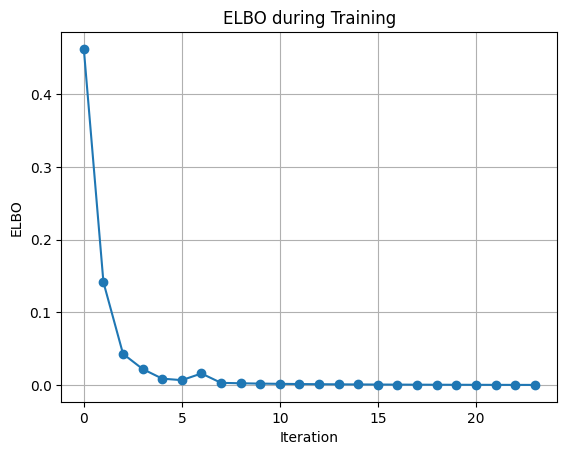

In [70]:
import matplotlib.pyplot as plt

# Assuming `loss_history` contains the ELBO values recorded during training
loss_history = [ 0.46215331, 0.14158996, 0.04309680, 0.02228139, 0.00903893, 0.00696392, 
               0.01614696, 0.00327198, 0.00268209, 0.00223781, 0.00189337, 0.00162048, 0.00140052, 0.00122064, 0.00107173,
               0.00094712, 0.00084186, 0.00075220, 0.00067525, 0.00060877, 0.00055097, 0.00050044, 0.00045604, 0.00041684]

# Plotting the loss
plt.plot(loss_history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.title('ELBO during Training')
plt.grid(True)
plt.show()

## 7) Downstream analysis

This finishes the tutorial on how to train a MOFA model from python. To continue with the downstream analysis you can either use the [mofax](https://github.com/gtca/mofax) python package or the [MOFA2](https://www.bioconductor.org/packages/release/bioc/html/MOFA2.html) R package. Please, visit our [tutorials](https://biofam.github.io/MOFA2/tutorials.html) webpage for more information.

In [8]:
import mofax as mofa
model = mofa.mofa_model("/tmp\mofa_20240320-113324.hdf5")

In [9]:
for k in model.factors.keys():
    print(k)

group_0
group_1


In [43]:
model.factors['group_0'][:].shape[1]

705

In [65]:
num_samples = model.factors['group_0'][:].shape[1]

X = np.concatenate([model.factors['group_0'][:], model.factors['group_1'][:]], axis=1).T
labels = np.array([0] * num_samples + [1] * num_samples)

In [55]:
X.shape, labels.shape

((1410, 9), (1410,))

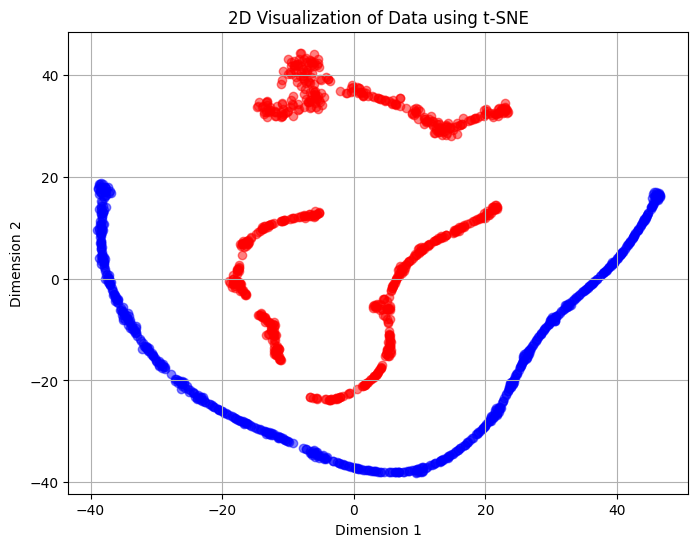

In [78]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming your data is stored in a numpy matrix called data_matrix
# data_matrix.shape should be (1410, 9)

# Initialize TSNE with 2 components (for 2D visualization)
tsne = TSNE(n_components=2, random_state=42)

# Perform dimensionality reduction
data_2d = tsne.fit_transform(X)

# Plot the reduced data
plt.figure(figsize=(8, 6))
plt.scatter(data_2d[:705, 0], data_2d[:705, 1], alpha=0.5, color='blue')
plt.scatter(data_2d[705:, 0], data_2d[705:, 1], alpha=0.5, color='red')
plt.title('2D Visualization of Data using t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.5070921985815603
              precision    recall  f1-score   support

           0       0.51      0.59      0.55       143
           1       0.50      0.42      0.45       139

    accuracy                           0.51       282
   macro avg       0.51      0.51      0.50       282
weighted avg       0.51      0.51      0.50       282



In [62]:
# DEBUG
# X = np.random.rand(1410,9)
# labels = np.random.randint(0, 2, size=(1410))
# labels

array([0, 0, 0, ..., 1, 1, 0])

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Assuming X and y are your feature matrix and target vector respectively

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Train the classifier
knn.fit(X_train, y_train)

# Predict the labels for test set
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [10]:
print(f"""\
Cells: {model.shape[0]}
Features: {model.shape[1]}
Groups of cells: {', '.join(model.groups)}
Views: {', '.join(model.views)}
""")

Cells: 1410
Features: 1488
Groups of cells: group_0, group_1
Views: RNA, copy_number, mutation_number



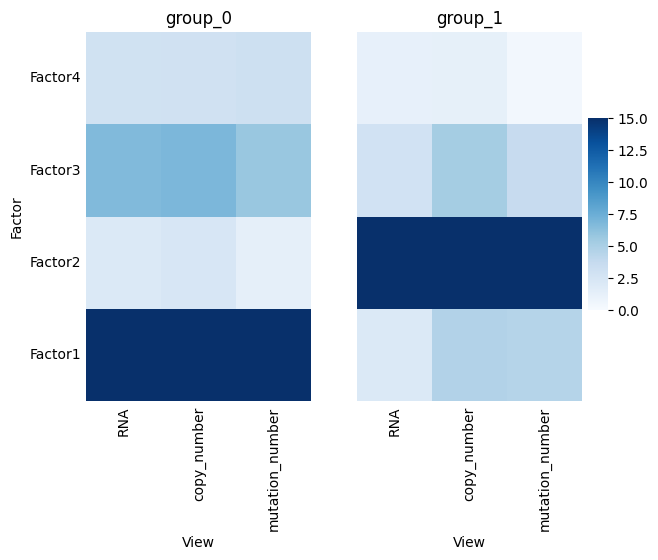

In [11]:
mofa.plot_r2(model, x='View', vmax=15)

### The core part of the trained model are 2 matrices: Z (factors) and W (weights, or loadings) matrices. The expectations for Z or W are easily accessible in different formats:

In [16]:
# HDF5 group
print("HDF5 group:\n", model.weights)

# np.ndarray
print("\nnp.ndarray: Weights\n", model.get_weights()[:3,:5])

# pd.DataFrame
print("\npd.DataFrame:\n", model.get_weights(df=True).iloc[:3,:5])

HDF5 group:
 <HDF5 group "/expectations/W" (3 members)>

np.ndarray: Weights
 [[-1.02665089e+00 -3.85899431e-02 -4.93918456e-01  5.76573372e-01
  -5.85145723e-02]
 [ 7.47484442e-02  4.97231882e-02  1.29223177e-04 -1.28362071e-01
   2.83297572e-02]
 [ 1.28555654e+00  7.80254468e-05  1.10020104e+00 -7.17461894e-01
  -4.95037563e-02]]

pd.DataFrame:
                  Factor1   Factor2   Factor3   Factor4   Factor5
rs_CLEC3A_RNA  -1.026651 -0.038590 -0.493918  0.576573 -0.058515
rs_CPB1_RNA     0.074748  0.049723  0.000129 -0.128362  0.028330
rs_SCGB2A2_RNA  1.285557  0.000078  1.100201 -0.717462 -0.049504


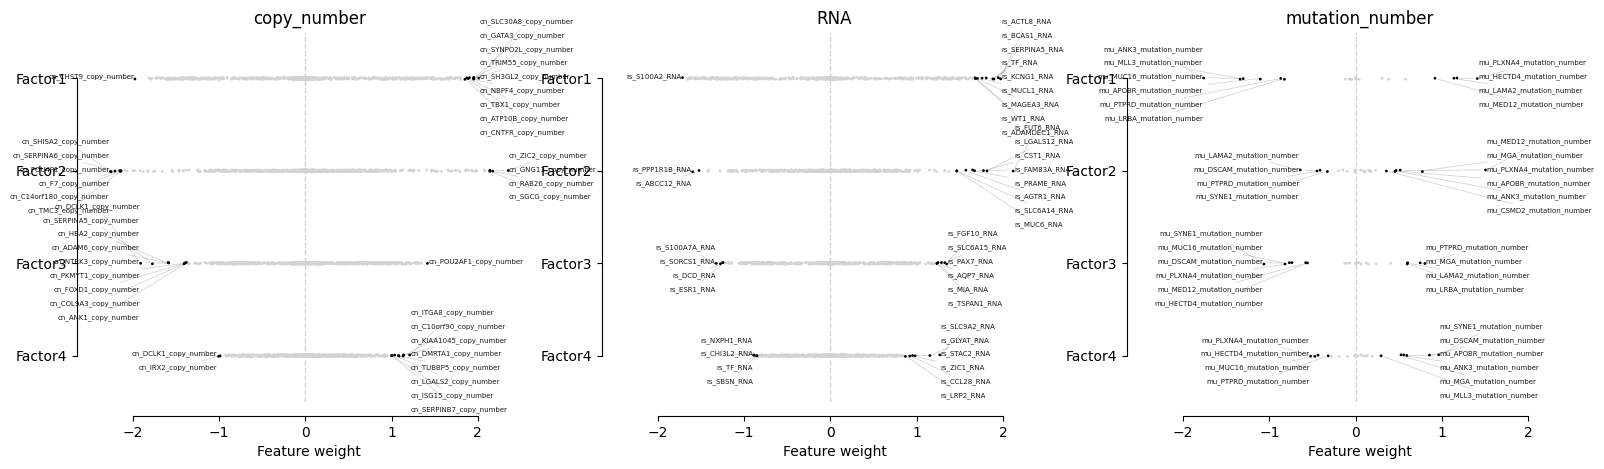

In [13]:
import mofax as mfx
ax = mfx.plot_weights(model, factor=2, n_features=10,
                      y_repel_coef=0.04, x_rank_offset=-150)
# repel coefficient and offsets can be useful to move labels around
# and there are x_rank_offset and x_rank_offset_neg for positive and negative weights respectively

If absolute loadings values are of interest, they can be compared between multiple factors with plot_weights_scatter. Marginal distributions can be added with hist=True or with kde=True.

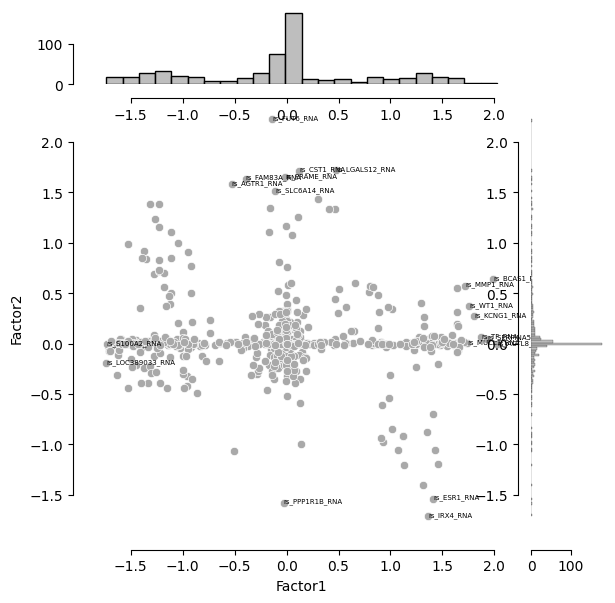

In [22]:
mfx.plot_weights_scatter(model, x="Factor1", y="Factor2",
                         hist=True, n_features=10)

If one wants to rank top features across multiple factors and see how their loadings differ between factors (and how loadings for different features are different for one factor), a dotplot can be useful.

Both absolute loadings or signed ones can be plotted easily (use w_abs boolean flag for that).

<Axes: title={'center': 'RNA'}, xlabel='factor', ylabel='feature'>

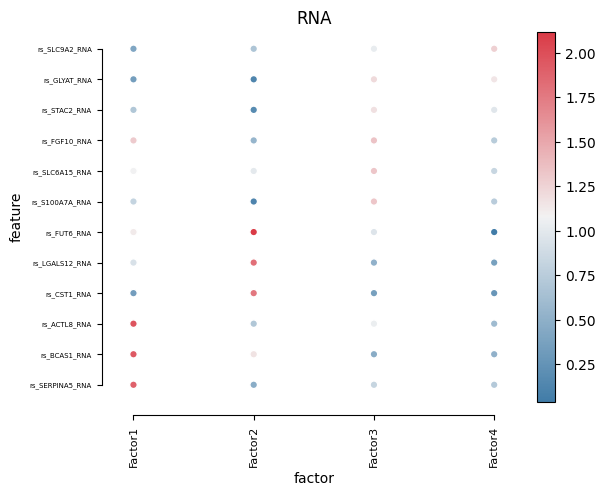

In [18]:
mfx.plot_weights_dotplot(model, n_features=3, 
                         w_abs=True, 
                         factors=list(range(4)), 
                          yticklabels_size=5)

In [16]:
mfx.plot_weights_dotplot(model, n_features=3,  # Number of top features for every factor
                         w_abs=False, 
                         factors=list(range(8)), yticklabels_size=5)

IndexError: index 4 is out of bounds for axis 1 with size 4

To compare factors defined by weights, a simple correlation could be useful. It is simple and might not suite analysis of complicated scenarios with some weights being correlated, yet it is a useful overview on weights.

<Axes: >

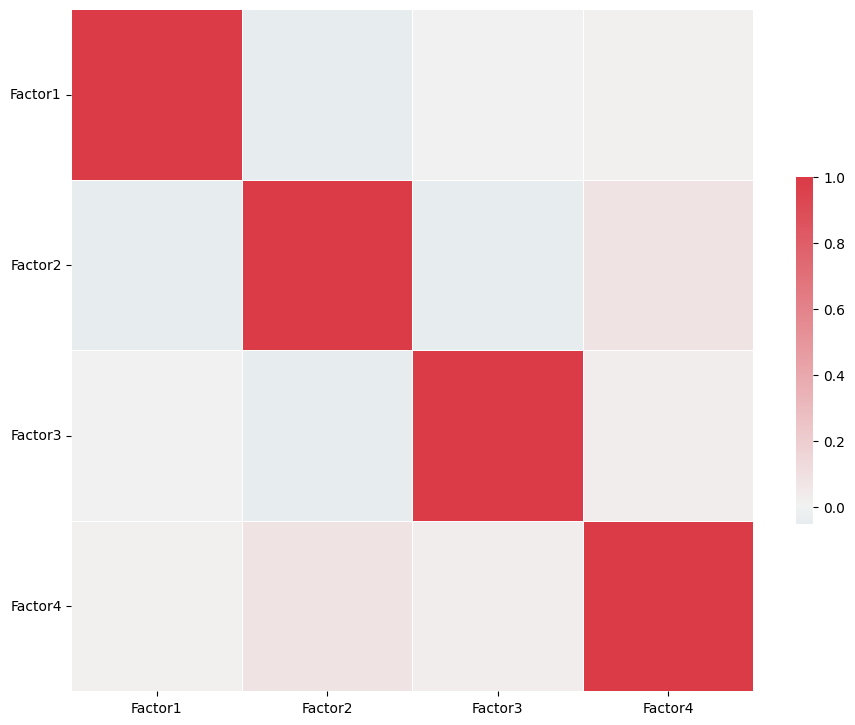

In [15]:
mfx.plot_weights_correlation(model)

One of the key ways to investigate how different sources of variation (factors) very across different views (omics) and groups (groups of cells) is to reconstruct the features times cells matrix, one factor at a time, and to compare it with the original data.

In [24]:
model.get_r2(factors=list(range(4))).sort_values("R2", ascending=False).head()

,Factor,View,Group,R2
4,Factor2,copy_number,group_1,28.074997
1,Factor1,copy_number,group_0,26.252660
5,Factor2,mutation_number,group_1,26.095904
0,Factor1,RNA,group_0,24.720829
2,Factor1,mutation_number,group_0,23.443023


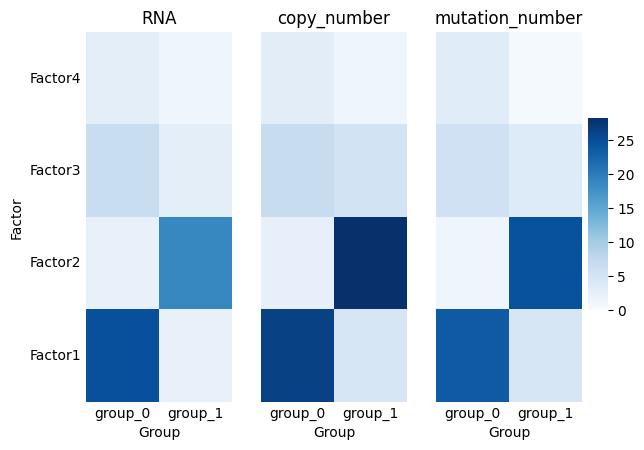

In [14]:
mfx.plot_r2(model, factors=list(range(10)), cmap="Blues")

And a heatmap with Pearson correlation coefficient values:

Text(0.5, 1.0, 'Pearson r')

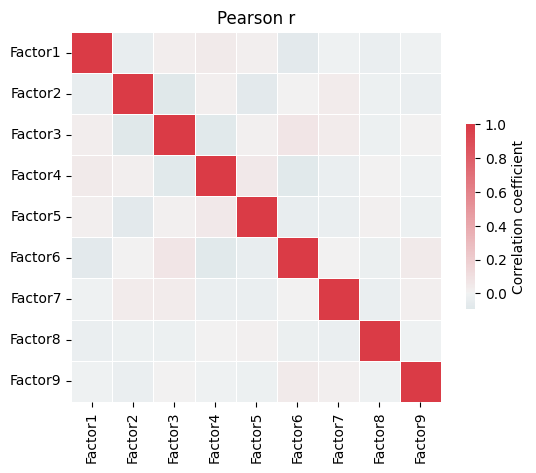

In [47]:
mfx.plot_factors_correlation(model); plt.title("Pearson r")

In [52]:
project_data(data_dt)

NameError: name 'project_data' is not defined